# Automatic Differentiation with `torch.autograd`

Deep neural networks enable efficient calculations of gradients through the *back propagation* operation, the computed gradients can thus be used to help the network perform descent steps on the objective (loss) function. With PyTorch's built-in differentiation engine called `torch.autograd`, we can perform automatic computation of the gradients for arbitrary computational graph.

In [1]:
import torch
from torchviz import make_dot

In [2]:
x = torch.ones(5) # input tensor
y = torch.zeros(3) # target tensor
w = torch.randn(5, 3, requires_grad=True) # weights
b = torch.randn(3, requires_grad=True) # biases
z = torch.matmul(x, w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y) # compute the cross entropy loss

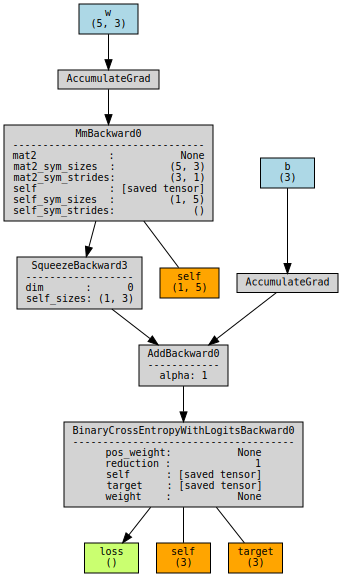

In [3]:
make_dot(loss, params={"w": w, "b": b, "loss": loss}, show_attrs=True, show_saved=True)

Here `w` and `b` are model parameters we would like to optimize, the computation is made possible by setting `requires_grad = True` when creating those tensors, or later by using `x.requires_grad_(True)`.

A function that we apply to tensors to construct computational graph is an instance of the class [`torch.autograd.Function`](https://pytorch.org/docs/stable/autograd.html#function), which can compute the function in the forward pass as well as the gradients in the backward pass (back propagation).

In [4]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7efea9c25480>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7efea9c254b0>


## Gradient Computation

By calling `loss.backward()`, we have the gradients computed: `w.grad` = $\partial loss / \partial w$ and `b.grad` = $\partial loss / \partial b$.

<div class="alert alert-info"><h4>Note</h4><p>
- We can only obtain `grad` properties for the leaf nodes of the computational graph which have `requires_grad` set to `True`, for other nodes in the computational graph, the gradients are not available.
- We can only perform `backward()` once on a given graph for gradient calculations for performance reasons, if we need to perform `backward()` multiple times, we need to set `retain_graph` to `True` in the `backward()` call.</p></div>

In [5]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.0013, 0.3332, 0.2128],
        [0.0013, 0.3332, 0.2128],
        [0.0013, 0.3332, 0.2128],
        [0.0013, 0.3332, 0.2128],
        [0.0013, 0.3332, 0.2128]])
tensor([0.0013, 0.3332, 0.2128])


## Disable Gradient Tracking

Oftentimes we only want to do forward pass (say for inference) and do not need gradient calculations, we can disable gradient tracking by the `torch.no_grad()` block:

In [6]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


or use the `detach()` method on the tensor,

In [7]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


There are reasons you might want to disable gradient tracking:
- To mark some parameters in your neural network as **frozen** parameters.
- To **speed up computations** when you are only doing forward pass, because computations on tensors that do not track gradients would be more efficient.

## More on Computational Graphs

Conceptually, autograd keeps a record of data (tensors) and all executed operations (along with the resulting new tensors) in a directed acyclic graph (DAG) consisting of [Function](https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function) objects. In this DAG, leaves are the input tensors, roots are the output tensors. By tracing this graph from roots to leaves, you can automatically compute the gradients using the chain rule.

In a forward pass, autograd does two things simultaneously:
- run the requested operation to compute a resulting tensor
- maintain the operation’s *gradient function* in the DAG.

The backward pass kicks off when `.backward()` is called on the DAG root. `autograd` then:
- computes the gradients from each `.grad_fn`,
- accumulates them in the respective tensor’s `.grad` attribute
- using the chain rule, propagates all the way to the leaf tensors.

<div class="alert alert-info"><h4>Note</h4><p><strong>DAGs are dynamic in PyTorch</strong> An important thing to note is that the graph is recreated from scratch; after each <code>.backward()</code> call, autograd starts populating a new graph. This is exactly what allows you to use control flow statements in your model; you can change the shape, size and operations at every iteration if needed.</p></div>

## Tensor Gradients and Jacobian Products

In many cases, we have a scalar loss function, and we need to compute the gradient with respect to some parameters. However, there are cases when the output function is an arbitrary tensor. In this case, PyTorch allows you to compute so-called **Jacobian product**, and not the actual gradient.

For a vector function $\vec{y}=f(\vec{x})$, where $\vec{x}=\langle x_1,\dots,x_n\rangle$ and $\vec{y}=\langle y_1,\dots,y_m\rangle$, a gradient of $\vec{y}$ with respect to $\vec{x}$ is given by the **Jacobian matrix**:

\begin{align}J=\left(\begin{array}{ccc}
      \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
      \end{array}\right)\end{align}

Instead of computing the Jacobian matrix itself, PyTorch allows you to compute **Jacobian Product** $v^T\cdot J$ for a given input vector $v=(v_1 \dots v_m)$. This is achieved by calling `backward` with $v$ as an argument. The size of $v$ should be the same as the size of the original tensor, with respect to which we want to compute the product:

In [10]:
v = torch.eye(4, 5, requires_grad=True) # input
out = (v + 1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{v.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{v.grad}")
v.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{v.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


Notice that when we call `backward` for the second time with the same argument, the value of the gradient is different. This happens because when doing `backward` propagation, PyTorch **accumulates the gradients**, i.e. the value of computed gradients is added to the `grad` property of all leaf nodes of computational graph. If you want to compute the proper gradients, you need to zero out the `grad` property before. In real-life training an *optimizer* helps us to do this.


<div class="alert alert-info"><h4>Note</h4><p>Previously we were calling <code>backward()</code> function without parameters. This is essentially equivalent to calling <code>backward(torch.tensor(1.0))</code>, which is a useful way to compute the gradients in case of a scalar-valued function, such as loss during neural network training.</p></div>